## Setup Environment

Requirements: <br>
• PySpark – 2.4.5<br>
• Matplotlib – 3.2.1<br>
• Sklearn – 0.22.2.post1<br>
• MLFlow – 1.10.0<br>
• mumpy – 1.18.5<br>

In [1]:
import pyspark #
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression 
import pyspark.sql.functions as F
import os
import seaborn as sns
import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib #
import matplotlib.pyplot as plt
import mlflow 
import mlflow.spark

In [2]:
os.environ["SPARK_LOCAL_IP"]='127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll()
print("pyspark: {}".format(pyspark.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))
print("mlflow: {}".format(mlflow.__version__))

23/03/17 10:04:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/Users/alimokh/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pyspark/sql/context.py:75: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


pyspark: 3.0.0
matplotlib: 3.6.2
seaborn: 0.12.2
sklearn: 1.1.3
mlflow: 1.10.0


### Load the Data

In [15]:
data_path = "../creditcard.csv"
df = spark.read.csv(data_path, header = True, inferSchema = True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove("Time")
numericCols.remove(labelColumn)
print(numericCols)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


## Data Preparation

### Create Data splits

Convert Spark data to Pandas and check the output

In [16]:
df.toPandas().head()

/Users/alimokh/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pyspark/sql/pandas/utils.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
23/03/17 10:13:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Select Features and Create normal and anomaly splits

In [17]:
stages = []
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,
outputCol="features")
stages += [assembler]
dfFeatures = df.select(F.col(labelColumn).alias('label'),
*numericCols )
normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020) 
anomaly = dfFeatures.filter("Class == 1")
normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed = 2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed = 2020)

Inspect feature data

In [18]:
dfFeatures.toPandas().head()

/Users/alimokh/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pyspark/sql/pandas/utils.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


,label,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Create Train and Test Sets

In [19]:
train_set = normal_train.union(anomaly_train)
test_set = normal_test.union(anomaly_test)

### Create Pipelines of feature vector

In [20]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dfFeatures)
train_set = pipelineModel.transform(train_set)
test_set = pipelineModel.transform(test_set)
selectedCols = ['label', 'features'] + numericCols
train_set = train_set.select(selectedCols)
test_set = test_set.select(selectedCols)
print("Training Dataset Count: ", train_set.count())
print("Test Dataset Count: ", test_set.count())

Training Dataset Count:  114389


Test Dataset Count:  28459


## Model Training and Evaluation

Training function

In [21]:
def train(spark_model, train_set): 
    trained_model = spark_model.fit(train_set)
    trainingSummary = trained_model.summary
    pyspark_auc_score = trainingSummary.areaUnderROC
    mlflow.log_metric("train_acc", trainingSummary.accuracy)
    mlflow.log_metric("train_AUC", pyspark_auc_score)
    print("Training Accuracy: ", trainingSummary.accuracy)
    print("Training AUC:", pyspark_auc_score)
    return trained_model

Evaluation Function

In [22]:
def evaluate(spark_model, test_set):
    evaluation_summary = spark_model.evaluate(test_set)
    eval_acc = evaluation_summary.accuracy
    eval_AUC = evaluation_summary.areaUnderROC
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("eval_AUC", eval_AUC)
    print("Evaluation Accuracy: ", eval_acc)
    print("Evaluation AUC: ", eval_AUC) 

### MLFlow Run

#### Training a model

In [23]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
mlflow.set_experiment("PySpark_CreditCard")
with mlflow.start_run():
    trainedLR = train(lr, train_set)
    evaluate(trainedLR, test_set)
    mlflow.spark.log_model(trainedLR,
    "creditcard_model_pyspark")
mlflow.end_run()

INFO: 'PySpark_CreditCard' does not exist. Creating a new experiment


23/03/17 10:57:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/17 10:57:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Training Accuracy:  0.9989509480806721
Training AUC: 0.9815891329227255


Evaluation Accuracy:  0.9989458519273341
Evaluation AUC:  0.9740334120466642


Load a saved Model

In [25]:
model = mlflow.spark.load_model("runs:/b12b24a5f8aa493eba45e306b4571386/creditcard_model_pyspark")

2023/03/17 11:11:15 INFO mlflow.spark: 'runs:/b12b24a5f8aa493eba45e306b4571386/creditcard_model_pyspark' resolved as 'file:///Users/alimokh/GitHub/ML-creditcardfraud/mlruns/4/b12b24a5f8aa493eba45e306b4571386/artifacts/creditcard_model_pyspark'
2023/03/17 11:11:15 INFO mlflow.spark: File 'file:///Users/alimokh/GitHub/ML-creditcardfraud/mlruns/4/b12b24a5f8aa493eba45e306b4571386/artifacts/creditcard_model_pyspark/sparkml' is already on DFS, copy is not necessary.


#### Make predictions

In [26]:
predictions = model.transform(test_set)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [27]:
print(f"AUC Score: {roc_auc_score(y_true, y_pred):.3%}")
print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.3%}")

AUC Score: 88.354%
Accuracy Score: 99.895%


#### Confusion Matrix

Text(0.5, 23.52222222222222, 'Predicted')

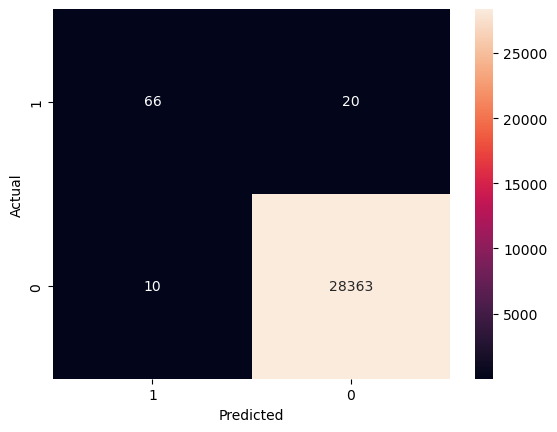

In [29]:
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g') 
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

It seems that anomaly are highly erronous